In [1]:
import pandas as pd
import networkx as nx

## Phase-1: Sybil-based non-spammer detection

In [2]:
users_df = pd.read_csv('truth_social/users.tsv', sep='\t', dtype={'id': 'Int64'})

/var/folders/d5/mkqk4pn93hg3l6gbhxjpbfy00000gn/T/ipykernel_58976/3386561370.py:8: DtypeWarning: Columns (1,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  users_df = pd.read_csv('truth_social/users.tsv', sep='\t', dtype={'id': 'Int64'})


In [74]:
follows_df = pd.read_csv('truth_social/follows.tsv', sep='\t')

social_graph = nx.Graph()
# limit to 500000 edges for now. otherwise takes too much time.
for index, row in follows_df.iterrows():
    social_graph.add_node(int(row['follower']), init_rank=1)
    social_graph.add_node(int(row['followed']), init_rank=1)
    social_graph.add_edge(int(row['follower']), int(row['followed']))
    if index > 500000:
        break

# Remove nodes with degree less than 3
nodes_to_be_removed = []
for node in social_graph.nodes:
    if social_graph.degree(node) < 3:
        nodes_to_be_removed.append(node)
social_graph.remove_nodes_from(nodes_to_be_removed)

In [75]:
social_graph.order()

44021

In [76]:
import importlib
import sybil
importlib.reload(sybil)
ranker = sybil.SybilRank(social_graph)

In [77]:
ranked_social_graph = ranker.rank()

Iteration done
Iteration done
Iteration done
Iteration done
Iteration done


In [81]:
node_ranks = []
for id, data in ranked_social_graph.nodes(data=True):
    node_ranks.append((id, data['rank']))

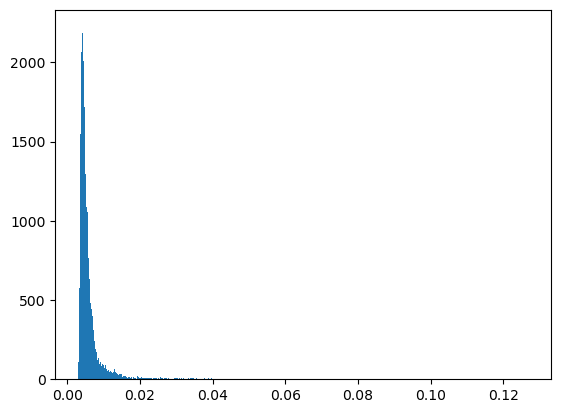

In [82]:
import matplotlib.pyplot as plt
plt.hist([x[1] for x in node_ranks], bins=1000)
plt.show()

In [83]:
node_ranks.sort(key=lambda x: x[1], reverse=True)

In [85]:
node_ranks_df = pd.DataFrame(node_ranks, columns=['id', 'rank'])
# sort node_ranks_df by rank
node_ranks_df.sort_values(by=['rank'], ascending=False, inplace=True)

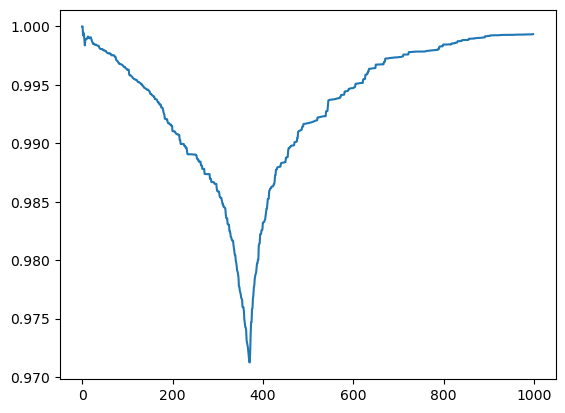

In [92]:
# for various values of threshold, plot the conductance of the graph
conductances = []
for thres in range(1, 1000):
    top_nodes = node_ranks_df.iloc[:thres]['id'].tolist()
    bottom_nodes = node_ranks_df.iloc[thres:]['id'].tolist()
    conductances.append(nx.algorithms.cuts.conductance(social_graph, top_nodes, bottom_nodes))
plt.plot(conductances)

In [104]:
# 370 seems to be a good threshold
whiteusers = node_ranks_df.iloc[370:]['id'].tolist()
whitelist = set()

from collections import defaultdict
external_url_df = pd.read_csv('truth_social/external_urls.tsv', sep='\t')
sharing_users = defaultdict(list)
for _, row in external_url_df.iterrows():
    sharing_users[row['url']].append(row['id'])

In [107]:
for user in whiteusers:
    user_posts = external_url_df[external_url_df['id'] == user]['url']
    for url in user_posts.to_list():
        url_users = sharing_users[url]
        if 2 * len(list(filter(lambda x: x in whiteusers, url_users))) >= len(url_users):
            whitelist.add(url)

In [121]:
user_link_graph = nx.Graph()
for url, users in sharing_users.items():
    if url in whitelist:
        continue
    for user1 in range(len(users)):
        for user2 in range(user1 + 1, len(users)):
            user_link_graph.add_edge(users[user1], users[user2], weight=1)

In [122]:
spammers = []
for node in user_link_graph.nodes:
    if user_link_graph.degree(node, weight='weight') > 10:
        spammers.append(node)

In [123]:
print(len(spammers), spammers)

14 [19741, 1139, 21926, 214, 816, 1232, 908, 5881, 7924, 11363, 10868, 10208, 10925, 3585]


## Evaluation

In [125]:
def truth_parser(line):
    line = list(filter(lambda x: len(x) > 0, line))
    ans = line[0:9]
    ans.append(' '.join(line[9:-3]))
    ans.extend(line[-3:])
    return ans
truths_df = pd.read_csv('truth_social/truths.tsv', sep='\t', on_bad_lines=truth_parser, engine='python')

for spammer in spammers:
    print(truths_df[truths_df['author'] == spammer]['text'].tolist())
    print('------------------')
    print(external_url_df[external_url_df['id'] == spammer]['url'].tolist())

['You’re obviously one of the lib dropouts.', 'Yup, same one.', 'So your posts show pro-America content yet now you’re all in on liberal lunacy?  I don’t get it.', 'Lol, the illiterate guy calling others illiterate.  That’s rich!', '@jjverdi - Tom Clancy wrote the book @dbongino mentioned.  You sure that was a movie too?  I’ll have to find it.', 'Damn, you suck at Photoshop.', 'Lol.  First time using Photoshop?', 'And now she’s like, “yes Joey!  I’ll join you in trying to hide crimes!”', 'The sheep are the ones who were told to get an untested vaccine and said “yup, ok, boss!”.  Wait, that’s you.', 'You mean since you can’t get anything right just like your scumbag god in the WH?', 'Facts don’t care about your feelings.  All you care about is your feelings.  That’s why you get so triggered when you’re exposed to facts.', 'Nope, no one avoids us, since we’re right 99% of the time.', 'I figured as much.', 'Again, you failed.  Do better.', 'No attempt at wit here, we do facts here.  Do be